## ATAC + MULTIOME GERM CELLS (april 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


**r2py setup**

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)

**Load data**

In [7]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/germcells_apr2021/"
experiment_prefix = 'germcells_'

In [8]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [9]:
adata.X

<2017x86770 sparse matrix of type '<class 'numpy.float32'>'
	with 9664993 stored elements in Compressed Sparse Row format>

**Setup of cisTopic**

In [10]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
adata

View of AnnData object with n_obs × n_vars = 2017 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

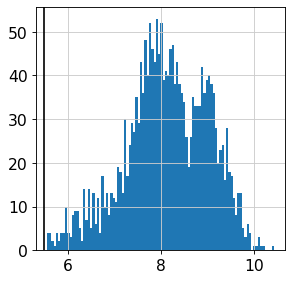

In [12]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5.5, color="black")

**Convert anndata to SingleCellExperiment**

In [13]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 86770 2017 
metadata(0):
assays(2): X binary_raw
rownames(86770): chr1:827160-827681 chr1:869566-870136 ...
  chrY:26408931-26409702 chrY:26563038-26563258
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(2017): 01-ACAGAAAAGAGGAATG-1 01-ACTTTCAAGGGCTCTC-1 ...
  07-TGGCCTTCATCCCTCA-1 07-TGTGGCGAGACACAAT-1
colData names(9): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_200_genes pct_counts_in_top_500_genes
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [14]:
%%R 

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject

An object of class cisTopic in project ATAC_cisTopic 
 86770 regions across 2017 samples.


In [15]:
%%R -i outdir -i experiment_prefix
#options(future.globals.maxSize = 1000 * 1024^2)

topics_vec <- c(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
                                   seed = 1712, 
                                   nCores = 16, 
                                   iterations = 500
                                  )

## Save trained models
saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

[1] "Exporting data..."
[1] "Run models..."


In [16]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

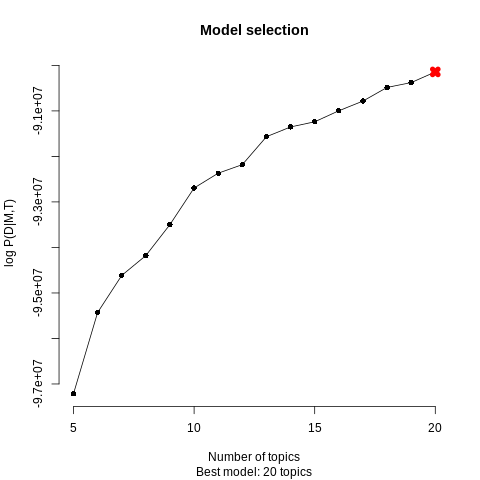

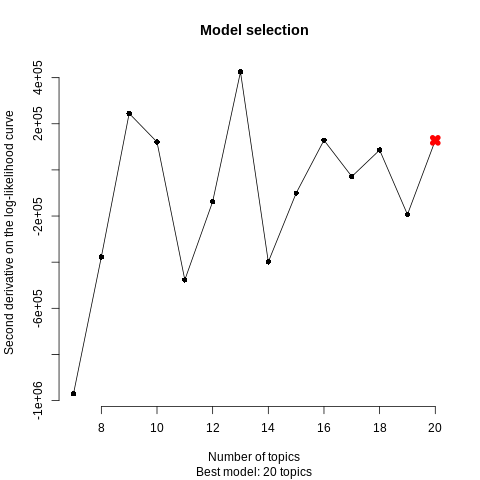

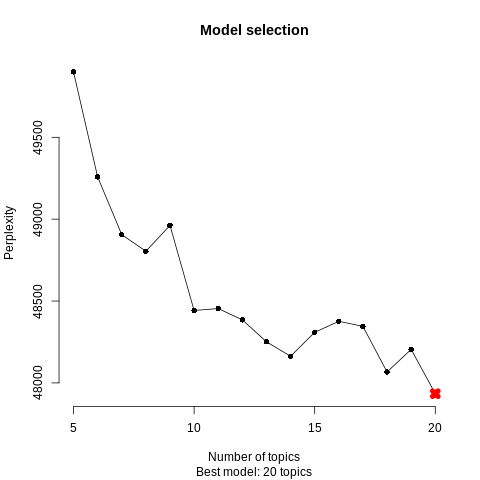

In [155]:
%%R

cistopic_model <- selectModel(cisTopicObject, type = "maximum")

In [156]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]   20 2017


In [157]:
topicXcell

array([[0.02780816, 0.0637156 , 0.18994924, ..., 0.21070111, 0.0099503 ,
        0.01180331],
       [0.15023138, 0.10706422, 0.18467005, ..., 0.10180988, 0.00454032,
        0.00585221],
       [0.22397981, 0.16706422, 0.06588832, ..., 0.08313126, 0.05023718,
        0.04751888],
       ...,
       [0.21022297, 0.20880734, 0.12142132, ..., 0.08769988, 0.09416083,
        0.08122977],
       [0.07888094, 0.06444954, 0.04585448, ..., 0.04060798, 0.04093065,
        0.04167566],
       [0.02419016, 0.02041284, 0.02585448, ..., 0.03029345, 0.06270612,
        0.05912442]])

In [158]:
adata.obsm['X_cistopic_20'] = topicXcell.T

#### Visualize dimensionality reduction results

In [159]:
sc.pp.neighbors(adata, use_rep="X_cistopic_20")

In [160]:
sc.tl.umap(adata, min_dist = 1, spread = 1.5)

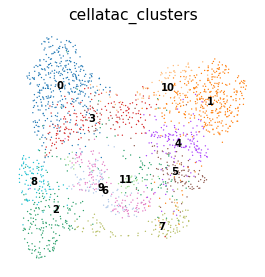

In [161]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 6, legend_loc = 'on data', legend_fontsize = 9)


In [162]:
adata

AnnData object with n_obs × n_vars = 2017 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_11', 'X_umap', 'X_cistopic_14', 'X_cistopic_18', 'X_cistopic_20'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

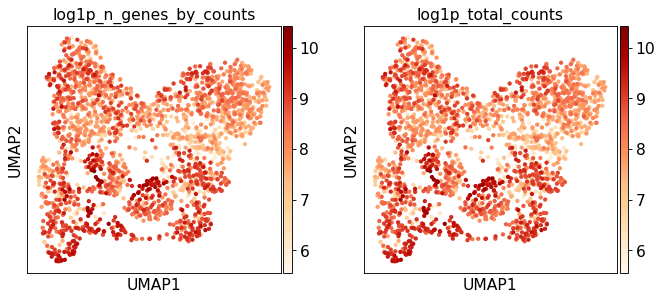

In [163]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

#### Add metadata

In [164]:
adata.shape

(2017, 86770)

In [165]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

04    379
06    290
05    264
02    244
08    221
03    214
17    158
16     58
10     48
15     46
14     29
01     16
07     15
12     14
13      9
11      7
09      5
Name: code, dtype: int64

In [166]:
# Sample from code 
sample_dictionary = {'01' : 'FCA_GND8046539', '02' : 'HD_F_GON9479871', '03' : 'HD_F_GON9479873', 
                    '04' : 'HD_F_GON9479874', '05' : 'HD_F_GON9479875', '06' : 'HD_F_GON9883959', 
                     '07' : 'HD_F_GON9883960', '08' : 'FCA_GND8768481', '09' : 'FCA_GND8768482', 
                    '10' : 'FCA_GND8768485', '11' : 'FCA_GND8795927', '12' : 'FCA_GND8795928', 
                    '13' : 'FCA_GND9332157', '14' : 'HD_F_GON9525611', '15' : 'HD_F_GON9525612', 
                    '16' : 'HD_F_GON9525613', '17' : 'HD_F_GON9525614'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

HD_F_GON9479874    379
HD_F_GON9883959    290
HD_F_GON9479875    264
HD_F_GON9479871    244
FCA_GND8768481     221
HD_F_GON9479873    214
HD_F_GON9525614    158
HD_F_GON9525613     58
FCA_GND8768485      48
HD_F_GON9525612     46
HD_F_GON9525611     29
FCA_GND8046539      16
HD_F_GON9883960     15
FCA_GND8795928      14
FCA_GND9332157       9
FCA_GND8795927       7
FCA_GND8768482       5
Name: sample, dtype: int64

In [167]:
sex_dictionary = {'FCA_GND8795927' : 'male',  
                 'FCA_GND8795928' : 'male', 'FCA_GND8768482' : 'male',  
                 'FCA_GND8768481' : 'male', 'FCA_GND8768487' : 'male', 
                 'HD_F_GON9479872' : 'male', 'HD_F_GON9525611' : 'male', 'HD_F_GON9525612' : 'male', 
                 'FCA_GND9332157' : 'male',
                 'FCA_GND8046539' : 'female', 'FCA_GND8768484' : 'female', 'FCA_GND8768483' : 'female', 
                    'HD_F_GON9479874' : 'female', 'HD_F_GON9479871' : 'female', 'HD_F_GON9479873' : 'female',
                  'HD_F_GON9479875' : 'female', 
                    'FCA_GND8768485' : 'female', 'HD_F_GON9525613' : 'female', 'HD_F_GON9525614' : 'female',
                 'HD_F_GON9883959' : 'female', 'HD_F_GON9883960' : 'female'}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

female    1686
male       331
Name: sex, dtype: int64

In [168]:
stage_dictionary = { 'FCA_GND8795927' : '7 PCW', 
                   'FCA_GND8795928' : '12 PCW', 'FCA_GND8768482' : '11 PCW',  
                   'FCA_GND8768481' : '19 PCW', 'FCA_GND8768487' : '12 PCW', 
                 'HD_F_GON9479872' : '15 PCW', 'HD_F_GON9525611' : '12 PCW', 'HD_F_GON9525612' : '12 PCW', 
                   'FCA_GND9332157' : '17 PCW',
                   'FCA_GND8046539' : '8 PCW', 'FCA_GND8768484' : '8 PCW', 'FCA_GND8768483' : '14 PCW', 
                    'HD_F_GON9479874' : '14 PCW', 'HD_F_GON9479871' : '14 PCW', 'HD_F_GON9479873' : '13 PCW',
                  'HD_F_GON9479875' : '14 PCW', 
                    'FCA_GND8768485' : '9 PCW', 'HD_F_GON9525613' : '14 PCW', 'HD_F_GON9525614' : '14 PCW', 
                   'HD_F_GON9883959' : '18 PCW', 'HD_F_GON9883960' : '21 PCW'}
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

14 PCW    1103
18 PCW     290
19 PCW     221
13 PCW     214
12 PCW      89
9 PCW       48
8 PCW       16
21 PCW      15
17 PCW       9
7 PCW        7
11 PCW       5
Name: stage, dtype: int64

In [169]:
individual_dictionary = {'FCA_GND8795927' : 'Hrv17',  
                   'FCA_GND8795928' : 'Hrv18', 'FCA_GND8768482' : 'Hrv10',  
                   'FCA_GND8768481' : 'Hrv3', 'FCA_GND8768487' : 'Hrv15', 
                 'HD_F_GON9479872' : 'Hrv40', 'HD_F_GON9525611' : 'Hrv15', 'HD_F_GON9525612' : 'Hrv15', 
                        'FCA_GND9332157' : 'Hrv21',
                        'FCA_GND8046539' : 'F81', 'FCA_GND8768484' : 'Hrv12', 'FCA_GND8768483' : 'Hrv11', 
                    'HD_F_GON9479874' : 'Hrv50', 'HD_F_GON9479871' : 'Hrv39', 'HD_F_GON9479873' : 'Hrv49',
                  'HD_F_GON9479875' : 'Hrv50', 
                    'FCA_GND8768485' : 'Hrv13', 'HD_F_GON9525613' : 'Hrv39', 'HD_F_GON9525614' : 'Hrv39',
                        'HD_F_GON9883959' : 'Hrv59', 'HD_F_GON9883960' : 'Hrv58'}
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

Hrv50    643
Hrv39    460
Hrv59    290
Hrv3     221
Hrv49    214
Hrv15     75
Hrv13     48
F81       16
Hrv58     15
Hrv18     14
Hrv21      9
Hrv17      7
Hrv10      5
Name: individual, dtype: int64

**Plot metadata information**

... storing 'code' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


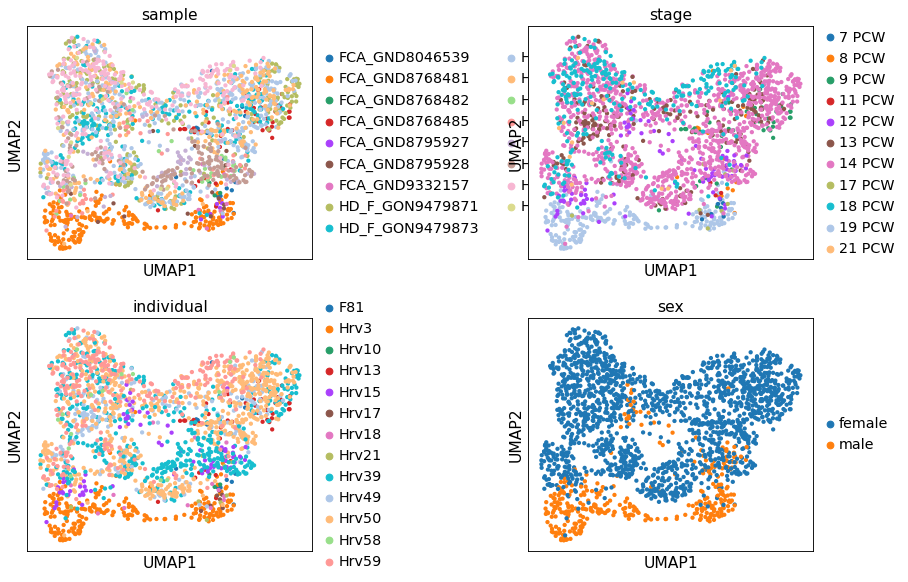

In [170]:
sc.pl.umap(adata, color = ['sample', 'stage', 'individual', 'sex'], ncols = 2, wspace = 0.6)

Explore the region x topic probability matrix 

In [171]:
#%%R 

#install.packages("bigmemory")

In [172]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [173]:
%%R
dim(p_mat)

[1] 86770  2017


In [174]:
p_mat

array([[2.81466068e-05, 2.81101728e-05, 2.22168456e-05, ...,
        2.03142884e-05, 3.03450302e-05, 2.33726818e-05],
       [3.84772785e-06, 8.95690229e-06, 9.77172565e-06, ...,
        9.56553888e-06, 1.98292985e-05, 1.41317373e-05],
       [8.81634823e-07, 1.05449760e-06, 1.03352355e-06, ...,
        2.27565091e-06, 4.03247406e-06, 2.54759550e-06],
       ...,
       [3.44529375e-07, 2.96392872e-07, 2.97362308e-07, ...,
        3.01832462e-07, 5.60996367e-07, 4.92323304e-07],
       [7.49964266e-07, 2.01409655e-06, 6.72450369e-07, ...,
        5.53024140e-07, 2.43445280e-06, 2.57852045e-06],
       [4.84765460e-07, 9.55431424e-07, 4.57166020e-07, ...,
        4.52167057e-07, 1.11557292e-06, 1.19616469e-06]])

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [175]:
adata.layers["cistopic_p"] = p_mat.T

**Calculate de-noised gene scores**

In [176]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [177]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [178]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [179]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

In [180]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

In [181]:
gene_mat = adj_mat.dot(p_mat) 

In [182]:
gene_mat

array([[2.71268544e-05, 3.91529535e-05, 6.03212451e-05, ...,
        7.31574319e-05, 3.88563225e-05, 3.99763627e-05],
       [2.02185606e-05, 2.56762024e-05, 4.70218911e-05, ...,
        5.83843822e-05, 1.97308085e-05, 2.10902604e-05],
       [2.02185606e-05, 2.56762024e-05, 4.70218911e-05, ...,
        5.83843822e-05, 1.97308085e-05, 2.10902604e-05],
       ...,
       [5.03706624e-05, 4.81650716e-05, 5.50373360e-05, ...,
        8.02354988e-05, 7.79383551e-05, 8.11720577e-05],
       [2.72927708e-05, 2.47271125e-05, 2.32601405e-05, ...,
        3.08852555e-05, 4.12599731e-05, 4.23345714e-05],
       [3.97408225e-06, 5.92601592e-06, 3.12992485e-06, ...,
        2.70528060e-06, 6.31691807e-06, 6.41650649e-06]])

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [183]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [184]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

,gene_id
gene_name,
RP11-54O7.16,ENSG00000272438
RP11-54O7.1,ENSG00000230699
RP11-54O7.2,ENSG00000241180
RP11-54O7.3,ENSG00000223764
SAMD11,ENSG00000187634


In [185]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(2017, 12601)

In [186]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2017 × 12601
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [187]:
gene_adata.var_names_make_unique()

In [188]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_20'] = topicXcell.T

In [189]:
adata

AnnData object with n_obs × n_vars = 2017 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_11', 'X_umap', 'X_cistopic_14', 'X_cistopic_18', 'X_cistopic_20'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [190]:
# del adata.layers['cistopic_p']

In [191]:
adata

AnnData object with n_obs × n_vars = 2017 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_11', 'X_umap', 'X_cistopic_14', 'X_cistopic_18', 'X_cistopic_20'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

#### Save anndata objects

In [192]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [193]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

#### Proceed with gene_data to look at marker genes

In [194]:
sc.pp.neighbors(gene_adata, use_rep="X_cistopic_20")

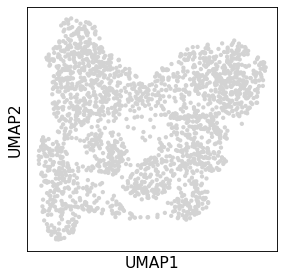

In [195]:
sc.tl.umap(gene_adata, min_dist = 1, spread = 1.5)
sc.pl.umap(gene_adata)

**Plot markers per cell type from RNA-seq**

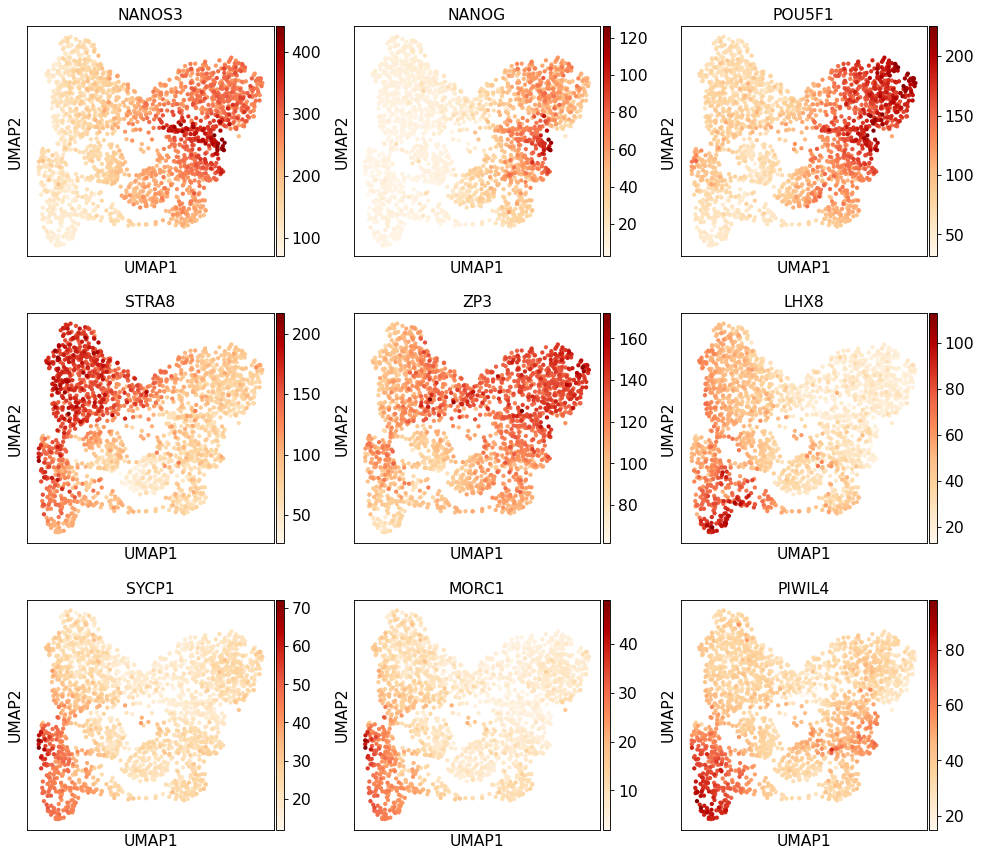

In [196]:
# PGC
sc.pl.umap(gene_adata, color = [ 'NANOS3', 'NANOG', 'POU5F1', 'STRA8', 'ZP3', 'LHX8', 'SYCP1', 
                               'MORC1', 'PIWIL4'], ncols = 3, color_map = 'OrRd')

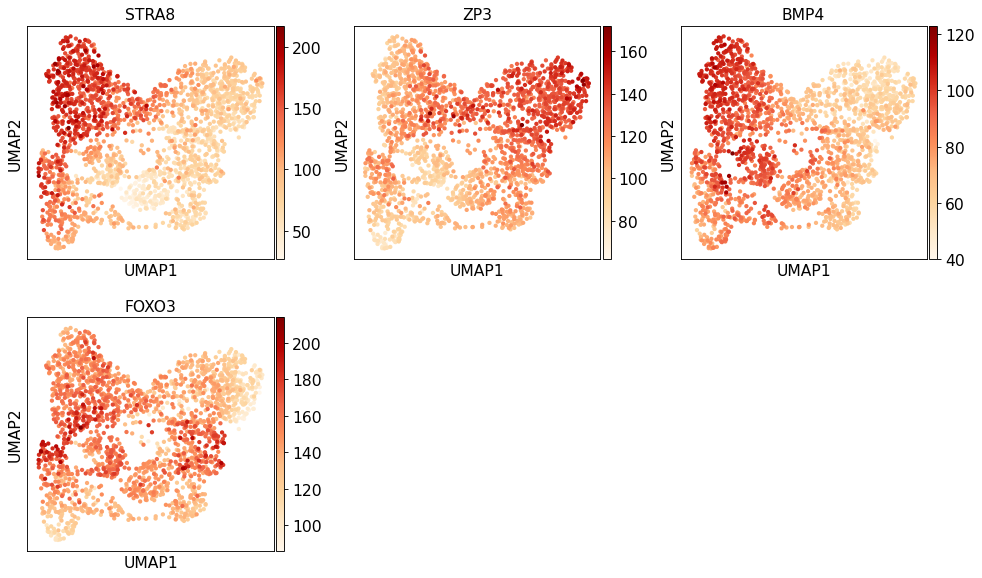

In [197]:
# Germ cells
sc.pl.umap(gene_adata, color = ['STRA8', 'ZP3', 'BMP4', 'FOXO3'], ncols = 3, color_map = 'OrRd')

In [198]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

#### End of notebook